# Testing prediction for enzyme activity

GFP/YFP dataset from DOI: 10.1021/acssynbio.8b00155

**Goal:** 

Use machine learning to try to predict the predicted activity of variants from a literature report.

**Learning Objectives:**
1. Learn how to vectorize amino acids by their chemical and physical properties
2. Determine if resampling techniques can overcome the difficulty of imbalance in enzyme activity
3. Practice coding

**Outline:**
1. Import the necessary modules
2. Import and clean the data
3. Vectorize the amino acids using the descriptors
4. Create desired features and targets
5. Machine learning: regression
6. Machine learning: classification
7. Summary


## Import the necessary modules
Several modules are required. I have imported the standard modules that I use for machine learning, and I have separated them into categories for clarity.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

%matplotlib inline

# Data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# Scoring methods
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.linear_model import LogisticRegression

## Import the data


Import the data from the excel file that was provided by the authors as supporting information. 

The `Rank` column denotes the ranking that was predicted from their machine learning alogrithm. 

The `Sequence` column denotes the identity of the four variable amino acids that are mutated in their experiments. 

The `Improved` column was added by me based on a figure from the paper. This figure labeled variants that were better than the reference YFP with their sequence idenitfier (here annotated as 1 for improvement). This figure also listed variants that were better than the reference GFP but not better than the reference YFP (here annotated as 2 for improvement). All other variants were annotated for improvement as '3'. The labeling of untested variants as three may be inaccurate, but this is the only dataset available, so I will proceed with this information. 

In [2]:
rank = pd.read_excel('Predicted-Best-mutants.xlsx', sheet_name = 'Sheet1')
rank.head()

,Rank,Sequence,Improved
0,1,GAYY,1
1,2,GAHY,1
2,3,GAFY,1
3,4,GAHH,2
4,5,GGHY,1


The sequence needs to be separated into individual amino acids and then changed to the three letter code.

In [3]:
reg_list = {'AA1': '(^[A-Z])', 
            'AA2': '[A-Z]([A-Z])[A-Z][A-Z]', 
            'AA3': '[A-Z][A-Z]([A-Z])[A-Z]', 
            'AA4': '([A-Z]$)'}

for key, value in reg_list.items():
    rank[key] = rank['Sequence'].str.extract(value, expand = True).astype('str')

rank.head()

,Rank,Sequence,Improved,AA1,AA2,AA3,AA4
0,1,GAYY,1,G,A,Y,Y
1,2,GAHY,1,G,A,H,Y
2,3,GAFY,1,G,A,F,Y
3,4,GAHH,2,G,A,H,H
4,5,GGHY,1,G,G,H,Y


In [4]:
AA_dict = {'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys', 'Q': 'Gln', 
           'E': 'Glu', 'G': 'Gly', 'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys', 'M': 'Met',
          'F': 'Phe', 'P': 'Pro', 'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'}

In [5]:
aa_1to3 = {'aa1': 'AA1', 'aa2': 'AA2', 'aa3': 'AA3', 'aa4': 'AA4'}
for key, value in aa_1to3.items():
    rank[key] = rank[value].map(AA_dict)
rank.head()

,Rank,Sequence,Improved,AA1,AA2,AA3,AA4,aa1,aa2,aa3,aa4
0,1,GAYY,1,G,A,Y,Y,Gly,Ala,Tyr,Tyr
1,2,GAHY,1,G,A,H,Y,Gly,Ala,His,Tyr
2,3,GAFY,1,G,A,F,Y,Gly,Ala,Phe,Tyr
3,4,GAHH,2,G,A,H,H,Gly,Ala,His,His
4,5,GGHY,1,G,G,H,Y,Gly,Gly,His,Tyr


## Convert the amino acid mutations to features/descriptors

The amino acids at each position need to be vectorized into features. I will test to amino acid descriptor sets Z-scale that is based on a principle component analysis (PCA) of multiple features. Because the descriptor set are created from PCA, it will not be possible to determine the importance of each feature. We may later try to use explicit descriptor sets, but the standard is to use PCA.

Z-scale (1998, PCA of 26 physicochemical descriptors): 10.1021/jm9700575

alternative that is used in the paper: \
T-scale (2007, PCA of 67 structural and topological descriptors): 10.1016/j.molstruc.2006.07.004

In [6]:
z_scale = pd.read_excel('AA-features.xlsx', sheet_name='Z-scale')

print(z_scale.dtypes)
z_scale.head()

#t_scale = pd.read_excel('AA-features.xlsx', sheet_name='T-scale')
#t_scale.head()

no.         int64
abbrev     object
namea      object
z1        float64
z2        float64
z3        float64
z4        float64
z5        float64
dtype: object


,no.,abbrev,namea,z1,z2,z3,z4,z5
0,1,Ala,alanine,0.24,-2.32,0.60,-0.14,1.30
1,2,Arg,arginine,3.52,2.50,-3.50,1.99,-0.17
2,3,Asn,asparagine,3.05,1.62,1.04,-1.15,1.61
3,4,Asp,aspartic acid,3.98,0.93,1.93,-2.46,0.75
4,5,Cys,cysteine,0.84,-1.67,3.71,0.18,-2.65


In [7]:
z_scale_dict = {'z1': 0, 'z2': 0, 'z3': 0, 'z4': 0, 'z5': 0}

for z in z_scale_dict.keys():
    z_scale_dict[z] = dict(zip(z_scale['abbrev'], z_scale[z]))
    
for aa in aa_1to3.keys():
    for z in z_scale_dict.keys():
        rank["{0}_{1}".format(aa, z)] = rank[aa].map(z_scale_dict[z])
rank.head()

,Rank,Sequence,Improved,AA1,AA2,AA3,AA4,aa1,aa2,aa3,...,aa3_z1,aa3_z2,aa3_z3,aa3_z4,aa3_z5,aa4_z1,aa4_z2,aa4_z3,aa4_z4,aa4_z5
0,1,GAYY,1,G,A,Y,Y,Gly,Ala,Tyr,...,-2.54,2.44,0.43,0.04,-1.47,-2.54,2.44,0.43,0.04,-1.47
1,2,GAHY,1,G,A,H,Y,Gly,Ala,His,...,2.47,1.95,0.26,3.90,0.09,-2.54,2.44,0.43,0.04,-1.47
2,3,GAFY,1,G,A,F,Y,Gly,Ala,Phe,...,-4.22,1.94,1.06,0.54,-0.62,-2.54,2.44,0.43,0.04,-1.47
3,4,GAHH,2,G,A,H,H,Gly,Ala,His,...,2.47,1.95,0.26,3.90,0.09,2.47,1.95,0.26,3.90,0.09
4,5,GGHY,1,G,G,H,Y,Gly,Gly,His,...,2.47,1.95,0.26,3.90,0.09,-2.54,2.44,0.43,0.04,-1.47


## Features and Targets

The features and targets will now be extracted from the information in the dataframe `rank`. Two targets will be used: i) the rank provided by the machine learning done in the paper and ii) the semi-experimental classification using the `Improvement` annotations.

The experimental classification is divided into three categories:
1. Better than YFP (12 variants)
2. Better than GFP (66 variants)
3. Not improved over GFP (159,767 variants)

These categories are highly imbalanced. Most of the proteins are within category number three.

In [8]:
features = rank.loc[:, ['aa1_z1']].copy()

for i in list(range(1, 5)):
    for j in list(range(1, 6)):
        features["aa{0}_z{1}".format(i, j)] = rank.loc[:, ("aa{0}_z{1}".format(i, j))].copy()

features.head()

,aa1_z1,aa1_z2,aa1_z3,aa1_z4,aa1_z5,aa2_z1,aa2_z2,aa2_z3,aa2_z4,aa2_z5,aa3_z1,aa3_z2,aa3_z3,aa3_z4,aa3_z5,aa4_z1,aa4_z2,aa4_z3,aa4_z4,aa4_z5
0,2.05,-4.06,0.36,-0.82,-0.38,0.24,-2.32,0.60,-0.14,1.30,-2.54,2.44,0.43,0.04,-1.47,-2.54,2.44,0.43,0.04,-1.47
1,2.05,-4.06,0.36,-0.82,-0.38,0.24,-2.32,0.60,-0.14,1.30,2.47,1.95,0.26,3.90,0.09,-2.54,2.44,0.43,0.04,-1.47
2,2.05,-4.06,0.36,-0.82,-0.38,0.24,-2.32,0.60,-0.14,1.30,-4.22,1.94,1.06,0.54,-0.62,-2.54,2.44,0.43,0.04,-1.47
3,2.05,-4.06,0.36,-0.82,-0.38,0.24,-2.32,0.60,-0.14,1.30,2.47,1.95,0.26,3.90,0.09,2.47,1.95,0.26,3.90,0.09
4,2.05,-4.06,0.36,-0.82,-0.38,2.05,-4.06,0.36,-0.82,-0.38,2.47,1.95,0.26,3.90,0.09,-2.54,2.44,0.43,0.04,-1.47


In [9]:
target_rank = rank.loc[:, ['Rank']].copy()
target_class = rank.loc[:, ['Improved']].copy()
target_class.head()

,Improved
0,1
1,1
2,1
3,2
4,1


In [10]:
target_class['Improved'].value_counts()

3    159767
2        66
1        12
Name: Improved, dtype: int64

The data is now ready for analysis. To streamline analysis, I will prepare a few functions for modeling and analysis.

## Functions for machine learning

I will define functions for modeling the data by regression or classification.
Resampling for the classification methods was set to SMOTEENN because this performed the best in earlier studies. The code for that is below.

**I have converted this to a Markdown so that it doesn't run.**

    `%%time
    smote_methods = [SMOTE, ADASYN, SMOTETomek, SMOTEENN]

    for method in smote_methods:
        x_values = features.values
        Sscaler = preprocessing.StandardScaler()
        x_scaled = Sscaler.fit_transform(x_values)
        X_train, X_test, y_train, y_test = train_test_split(x_scaled, target_class, 
                                                            test_size = 0.25, random_state = 50)

        sm = method(random_state=30)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

        clf = AdaBoostClassifier(algorithm='SAMME.R', random_state=30, n_estimators=100, learning_rate=1.0, 
                              base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
        clf.fit(X_train_res, y_train_res.values.ravel())

        y_pred = clf.predict(X_test)
        score = round(clf.score(X_test, y_test), 3)
        recall = round(recall_score(y_test, y_pred, average='weighted'), 3)
        f1 = round(f1_score(y_test, y_pred, average='weighted'),3)
        print(score, recall, f1)

        unique1, counts1 = np.unique(y_train, return_counts=True)
        print(dict(zip(unique1, counts1)))

        unique2, counts2 = np.unique(y_train_res, return_counts=True)
        print(dict(zip(unique2, counts2)))

        disp = plot_confusion_matrix(clf, X_test, y_test,
                                        display_labels=[1, 2, 3],
                                        cmap=plt.cm.Purples,
                                        normalize='true')
        disp.ax_.set_xticklabels([1, 2, 3])
        disp.ax_.set_title(method)
        plt.show()`

In [11]:
def modeling(kind, Method):
    outputs = {}
    
    x_values = features.values
    Sscaler = preprocessing.StandardScaler()
    x_scaled = Sscaler.fit_transform(x_values)
    
    if kind == 'regression':
        X_train, X_test, y_train, y_test = train_test_split(x_scaled, target_rank, 
                                                        test_size = 0.25, random_state = 50)
        reg = Method
        reg.fit(X_train, y_train.values.ravel())
        y_pred = reg.predict(X_test)

        outputs['y_test'] = y_test  
        outputs['y_pred'] = y_pred
        outputs['reg'] = reg
        outputs['reg_score'] = round(reg.score(X_test, y_test), 3)

        
    if kind == 'classification':
        X_train, X_test, y_train, y_test = train_test_split(x_scaled, target_class, 
                                                        test_size = 0.25, random_state = 50)
        sm = SMOTEENN(random_state=30)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        
        clf = Method
        clf.fit(X_train_res, y_train_res.values.ravel())
        y_pred = clf.predict(X_test)
        
        outputs['X_test'] = X_test
        outputs['y_test'] = y_test
        outputs['y_pred'] = y_pred
        outputs['clf'] = clf
        outputs['score'] = round(clf.score(X_test, y_test), 3)
        outputs['recall'] = round(recall_score(y_test, y_pred, average='weighted'), 3)
        outputs['f1'] = round(f1_score(y_test, y_pred, average='weighted'),3)  

    return outputs

In [12]:
def six_plot(kind, **results):
    row_loc = [0, 1]
    col_loc = [0, 1, 2]

    locations = [(row, col) for row in row_loc for col in col_loc]

    sns.set_context('notebook')
    
    if kind == 'regression':    
        fig, axs = plt.subplots(len(row_loc), len(col_loc), figsize=(16, 7.5), sharey=True, sharex=True)
        plt.subplots_adjust(hspace = 0.1, wspace = 0.05)
        for i, name, result in zip(locations, results.keys(), results.values()):        
            x = result['y_test']/10000
            y = result['y_pred']/10000
            axs[i].scatter(x, y, s=0.1)
            axs[i].plot([0, x.max()], [0, x.max()], color = 'black')
            axs[i].set_ylim(-1, 20)
            axs[i].set_xlim(-1, 17)
            axs[i].text(0, 18, '{0}: {1}'.format(name, result['reg_score']), fontsize=12)
        for i in list(range(0,3)):
            axs[1,i].set_xlabel('Actual Rank')
        for i in list(range(0,2)):
            axs[i,0].set_ylabel('Predicted Rank')

    if kind == 'classification':
        fig, axs = plt.subplots(len(row_loc), len(col_loc), figsize=(14, 9))
        for i, name, result in zip(locations, results.keys(), results.values()):
            disp = plot_confusion_matrix(result['clf'], result['X_test'], result['y_test'],
                                        display_labels=[1, 2, 3],
                                        cmap=plt.cm.Purples,
                                        normalize='true', ax=axs[i])
            disp.im_.colorbar.remove()
            disp.ax_.set_title(name)
            disp.ax_.set_xticklabels([1, 2, 3])

    plt.show()

In [13]:
def compare_test_pred(**results):
    for key, value in results.items():
        test1 = value['y_test'].copy()
        test1 = test1.reset_index()
    
    for key, value in results.items():
        test1['y_pred_{}'.format(key)] = pd.DataFrame(value['y_pred'])

    return test1

## Machine Learning: regression for 'rank' target

First, I will look at the ranking target that was defined above. 


**Regression models imported:**
1. LinearRegression
2. KNeighborsRegressor
3. DecisionTreeRegressor
4. RandomForestRegressor
5. AdaBoostRegressor
6. MLPRegressor

In [14]:
regressors = {'LRr': LinearRegression(), 
              'KNNr': KNeighborsRegressor(n_neighbors=4), 
              'DTr': DecisionTreeRegressor(), 
              'RFr': RandomForestRegressor(),
              'AdaBoostr': AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20, random_state=30)),
              'NNr': MLPRegressor(alpha=1, random_state=30, max_iter=1000, solver='lbfgs')}

In [15]:
%%time
reg_results = {}
for name, regressor in regressors.items():
    reg_results['{}'.format(name)] = modeling('regression', regressor)

CPU times: user 12min 4s, sys: 13.2 s, total: 12min 18s
Wall time: 4min 34s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


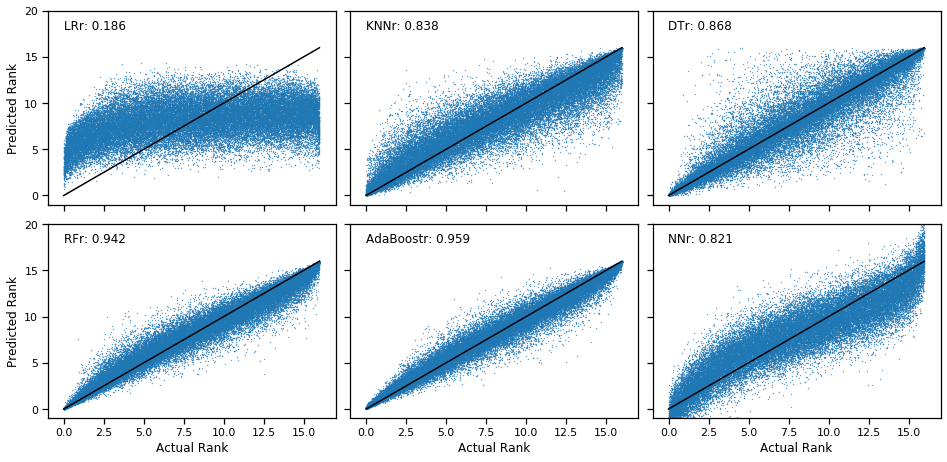

In [16]:
six_plot('regression', **reg_results)

It looks like the predictive power for this problem is good. The Neural Network did not converge, but the Random Forest and AdaBoost are both good methods for this regression modeling. 

The parameters of all of the samples could be further optimized. For now, I will just take a look at the outputs

In [17]:
reg_test_pred = compare_test_pred(**reg_results)
reg_test_pred.sort_values(by = 'index').head(20)

,index,Rank,y_pred_LRr,y_pred_KNNr,y_pred_DTr,y_pred_RFr,y_pred_AdaBoostr,y_pred_NNr
3756,0,1,24368.837385,98.25,3.0,7.80,472.0,-34913.917277
12230,17,18,11342.503474,2880.25,26.0,41.45,858.0,-28779.775291
27302,28,29,13052.182525,2195.75,27.0,27.40,1041.0,-20032.864446
1750,33,34,20391.224743,7471.50,65.0,113.75,1366.0,-38044.819207
22083,37,38,52989.405753,1504.50,36.0,61.07,1480.0,-25055.031247
16533,46,47,28804.524503,627.25,39.0,49.38,677.0,5778.518405
28930,49,50,22637.328481,3272.50,49.0,50.57,1041.0,-12667.545256
32337,50,51,42334.418606,5077.50,58.0,81.29,1211.0,-19953.256594
699,52,53,30358.757342,575.75,41.0,51.42,1177.0,-1696.840683
34780,54,55,9736.237597,9908.25,65.0,155.40,1341.0,-27783.912777


It looks like the prediction catches sample 1 in the prediction, which is in class 1. It also catches many of the samples that are in class 2. 

## Machine Learning: classification for 'improvement' target

Next, I will look at the improvement target that was defined above. 

**Classification models imported:**
1. Logistic Regression
2. Random Forest
3. AdaBoost
4. Neural Net
5. K-nearest neighbors
6. Gaussian Naive Bayes


In [18]:
classifiers = {'LogReg': LogisticRegression(random_state=30, max_iter = 500, multi_class = 'multinomial'), 
              'RFc': RandomForestClassifier(random_state = 30, n_estimators=100,  min_samples_split = 12, class_weight='balanced'),
              'AdaBoostc': AdaBoostClassifier(algorithm='SAMME.R', random_state=30, n_estimators=100, learning_rate=1.0, 
                          base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced')),
              'NNc': MLPClassifier(alpha=1, max_iter=500),
              'KNNc': KNeighborsClassifier(n_neighbors=15, weights='distance'), 
              'GaussianNBc': GaussianNB()}

In [19]:
%%time
clf_results = {}
for name, classifier in classifiers.items():
    clf_results['{}'.format(name)] = modeling('classification', classifier)

CPU times: user 14min, sys: 13.6 s, total: 14min 13s
Wall time: 12min 23s


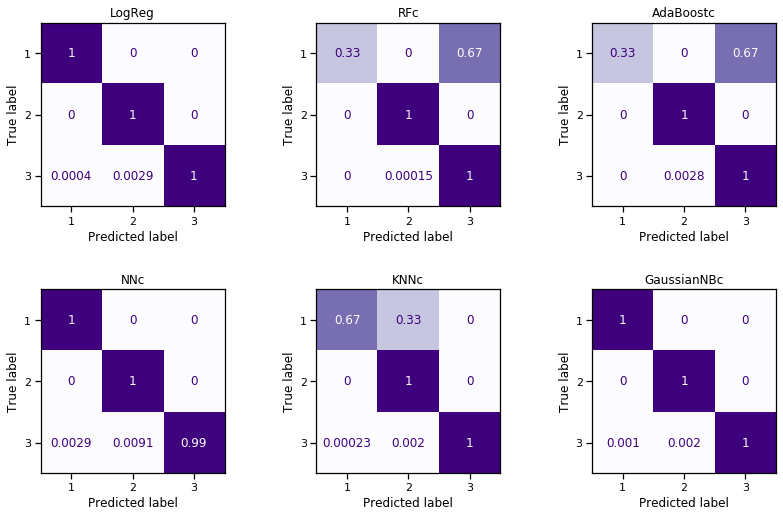

In [20]:
six_plot('classification', **clf_results)

It looks like the predictive power for the improvement target is also good. The ensemble methods are oddly not as predictive.

The parameters of all of the samples could be further optimized. For now, I will just take a look at the outputs

In [23]:
class_test_pred = compare_test_pred(**clf_results)
class_test_pred.sort_values(by = 'Improved').head(20)

,index,Improved,y_pred_LogReg,y_pred_RFc,y_pred_AdaBoostc,y_pred_NNc,y_pred_KNNc,y_pred_GaussianNBc
34780,54,1,1,3,3,1,1,1
1750,33,1,1,3,3,1,2,1
3756,0,1,1,1,1,1,1,1
32337,50,2,2,2,2,2,2,2
16533,46,2,2,2,2,2,2,2
12230,17,2,2,2,2,2,2,2
699,52,2,2,2,2,2,2,2
28930,49,2,2,2,2,2,2,2
27302,28,2,2,2,2,2,2,2
17155,70,2,2,2,2,2,2,2


## Conclusion

It looks like this project is predictive for both targets (ranking and improvement). The main thing to consider is that the input data needs to be very reliable. If the data is not reproducible, then the model will not be reliable.